# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 4
# Regularization, High Dimensionality, PCA


**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook even if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
%matplotlib inline

# Continuing Bike Sharing Usage Data

In this homework, we will focus on multiple linear regression, regularization, dealing with high dimensionality, and PCA. We will continue to build regression models for the Capital Bikeshare program in Washington D.C.  See Homework 3 for more information about the data.

*Note: please make sure you use all the processed data from HW 3 Part (a)...you make want to save the data set on your computer and reread the csv/json file here.


## Part (f): Regularization/Penalization Methods

As an alternative to selecting a subset of predictors and fitting a regression model on the subset, one can fit a linear regression model on all predictors, but shrink or regularize the coefficient estimates to make sure that the model does not "overfit" the training set. 

Use the following regularization techniques to fit linear models to the training set:
- Ridge regression
- Lasso regression
    
You may choose the shrikage parameter $\lambda$ from the set $\{10^{-5}, 10^{-4},...,10^{4},10^{5}\}$ using cross-validation. In each case, 

- How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrikage penalty) in Part (b) fropm HW 3? Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.
- List the predictors that are assigned a coefficient value close to 0 (say < 1e-10) by the two methods. How closely do these predictors match the redundant predictors (if any) identified in Part (c) from HW 3?
- Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.

First we read in the preprocessed data from HW3 and check that the data has been imported correctly.

In [2]:
bike_rentals_train_pp = pd.read_csv('../hwassets/data/Bikeshare_pp_train.csv',
                                    usecols=range(1, 30))
bike_rentals_test_pp = pd.read_csv('../hwassets/data/Bikeshare_pp_test.csv',
                                   usecols=range(1, 30))
display(bike_rentals_train_pp.head())
bike_rentals_test_pp.head()

,season_2,season_3,season_4,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,day_of_week_6,weather_2,weather_3,temp,atemp,humidity,windspeed,holiday,workingday,count
0,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0.623798,0.650106,0.920664,-0.928758,0,1,6073.0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,-0.180310,-0.054759,0.696852,-0.213502,0,1,6606.0
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0.802489,0.851495,-0.448383,0.803926,0,1,7363.0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,-1.520492,-1.565182,-0.332113,-0.269099,0,0,2431.0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0.534453,0.348021,1.975789,-1.199027,0,1,1996.0


,season_2,season_3,season_4,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,day_of_week_6,weather_2,weather_3,temp,atemp,humidity,windspeed,holiday,workingday,count
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,-1.152787,-1.170934,-0.429753,0.049862,0,1,3830.0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,-1.237691,-1.455602,0.211487,2.077744,0,1,2114.0
2,1,0,0,0,0,0,0,1,0,0,...,0,1,0,1.733956,1.770634,-0.385631,-0.523753,0,1,915.0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,-0.643362,-0.601598,-0.932739,1.011162,0,1,4322.0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1.054723,1.011520,0.523275,0.324419,0,0,6591.0


Now we select the regularization parameter $\lambda$ from cross-validation and fit the Ridge and Lasso regression models on the training data.

In [3]:
def cross_validate(estimator, param_grid, X, y, cv=3, scoring='r2'):
    grid_search_cv = GridSearchCV(estimator, param_grid=param_grid, cv=3,
                                  scoring=scoring, return_train_score=True)
    grid_search_cv.fit(X, y)
    return grid_search_cv.best_estimator_


def fit_model(estimator, X, y):
    estimator.fit(X, y)
    return pd.Series(estimator.coef_, index=X.columns)

In [4]:
lambdas = {'alpha': [10**i for i in range(-5, 6)]}
Xtrain = bike_rentals_train_pp.drop('count', axis='columns')
ytrain = bike_rentals_train_pp['count']
Xtest = bike_rentals_test_pp.drop('count', axis='columns')
ytest = bike_rentals_test_pp['count']

In [5]:
ridge = Ridge(random_state=1)
best_ridge = cross_validate(ridge, lambdas, Xtrain, ytrain)
ridge_coef = fit_model(best_ridge, Xtrain, ytrain)
print(ridge_coef)
print('sum of coefs L1-norm:', sum([abs(coef) for coef in ridge_coef]))
print('sum of coefs L2-norm:', sum([coef**2 for coef in ridge_coef]))

season_2         393.172558
season_3         172.179280
season_4         761.785438
month_2         -115.121866
month_3           88.890507
month_4          369.535648
month_5          133.372454
month_6         -312.374874
month_7         -529.544517
month_8          -89.294041
month_9          676.886869
month_10         503.423043
month_11         159.095865
month_12        -100.658217
day_of_week_1   -130.581134
day_of_week_2   -125.495343
day_of_week_3    124.317969
day_of_week_4     64.479041
day_of_week_5    126.173106
day_of_week_6    303.988692
weather_2         20.280511
weather_3       -676.143888
temp             682.808258
atemp            553.889947
humidity        -567.721919
windspeed       -266.413119
holiday         -158.559716
workingday       217.453354
dtype: float64
sum of coefs L1-norm: 8423.641171924373
sum of coefs L2-norm: 3930125.9527748106


In [6]:
lasso = Lasso(random_state=3, max_iter=10**5,
              selection='random')  # convergence issues
best_lasso = cross_validate(lasso, lambdas, Xtrain, ytrain)
lasso_coef = fit_model(best_lasso, Xtrain, ytrain)
print(lasso_coef)
print('sum of coefs L1-norm:', sum([abs(coef) for coef in lasso_coef]))
print('sum of coefs L2-norm:', sum([coef**2 for coef in lasso_coef]))

season_2          543.861927
season_3          113.454922
season_4          898.946725
month_2            -0.000000
month_3            14.047603
month_4           312.677260
month_5             0.000000
month_6          -354.588153
month_7          -495.859956
month_8            -0.000000
month_9           834.711018
month_10          484.026195
month_11           68.215006
month_12           -0.000000
day_of_week_1    -178.923213
day_of_week_2    -129.139964
day_of_week_3      17.604088
day_of_week_4       0.000000
day_of_week_5      11.175120
day_of_week_6     309.978800
weather_2          -0.000000
weather_3       -1058.378974
temp              857.462470
atemp             396.714215
humidity         -555.831919
windspeed        -254.429009
holiday            -0.000000
workingday        277.547940
dtype: float64
sum of coefs L1-norm: 8167.574478542821
sum of coefs L2-norm: 5130732.91767416


In general, the estimated coefficients for both Ridge and Lasso regression are smaller than the coefficients estimated by plain linear regression in part (b) from HW 3 due to the shrinkage penalty. More precisely, $\lvert \lvert \beta_{i} \rvert \rvert_{1}$ and $\lvert \lvert \beta_{i} \rvert \rvert^{2}_{2}$ are smaller. Moreover, we can see that the L1-norm value for Lasso regression is smaller than that for Ridge regression and the L2-norm value is smaller for Ridge regression than for Lasso regression. This is to be expected as these are the respective norms in the loss functions that these regression methods minimize. We also see that Ridge regression just shrinks the coefficients (no coefficient values are zero) whereas Lasso regression actually performs variable selection as it sets some of the parameter values to zero.

We can see that the predictors which are assigned a coefficient value of zero by Lasso regression are:
- month_2            
- month_5             
- month_8            
- month_12           
- day_of_week_4      
- weather_2       
- holiday  

It's a mixed bag with regards to how closely these predictors match the redundant predictors in part (c) from HW 3. We can see that the several of the month predictors have been elimated by the Lasso regression. `day_of_week_4`, `weather_2` and `holidat` were not particularly problematic, but have been eliminated. Some predictor pairs which were highly problematic such as `temp` and `atemp`, `day_of_week_6` and `workingday` and a few pairs of month and season still remain.

There a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`. The Ridge regression has the effect of these two predictors on the bike rental count as more comparable (with `temp` having a slightly greater effect) whereas Lasso regression has `temp` having a much larger effect than `atemp`.

We next analyze the performance of the two shrinkage methods for different training sample sizes:
- Generate random samples of sizes 100, 150, ..., 400 from the training set. You may use the following code to draw a random sample of a specified size from the training set:

In [7]:
#--------  sample
# A function to select a random sample of size k from the training set
# Input: 
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data)
#      k (size of sample) 
# Return: 
#      chosen sample of predictors and responses

def sample(x, y, k):
    n = x.shape[0] # No. of training points
    
    # Choose random indices of size 'k'
    subset_ind = np.random.choice(np.arange(n), k)
    
    # Get predictors and reponses with the indices
    x_subset = x[subset_ind, :]
    y_subset = y[subset_ind]
    
    return (x_subset, y_subset)

- Fit linear, Ridge and Lasso regression models to each of the generated sample. In each case, compute the $R^2$ score for the model on the training sample on which it was fitted, and on the test set.
- Repeat the above experiment for 10 random trials/splits, and compute the average train and test $R^2$ across the trials for each training sample size. Also, compute the standard deviation (SD) in each case.
- Make a plot of the mean training $R^2$ scores for the linear, Ridge and Lasso regression methods as a function of the training sample size. Also, show a confidence interval for the mean scores extending from **mean - SD** to **mean + SD**. Make a similar plot for the test $R^2$ scores.

How do the training and test $R^2$ scores compare for the three methods? Give an explanation for your observations. How do the confidence intervals for the estimated $R^2$ change with training sample size? Based on the plots, which of the three methods would you recommend when one needs to fit a regression model using a small training sample?

*Hint:* You may use `sklearn`'s `RidgeCV` and `LassoCV` classes to implement Ridge and Lasso regression. These classes automatically perform cross-validation to tune the parameter $\lambda$ from a given range of values. You may use the `plt.errorbar` function to plot confidence bars for the average $R^2$ scores.

In [8]:
sample_sizes = list(range(100, 401, 50))
models = {'linear': LinearRegression(),
          'ridge': Ridge(alpha=best_ridge.alpha, random_state=4),
          'lasso': Lasso(alpha=best_lasso.alpha, random_state=6,
                         max_iter=10**5)}

In [9]:
def models_r_squared(estimators, Xtrain, ytrain, Xtest, ytest,
                     sample_sizes, num_trials=10):
    models_r2 = []
    for name, model in models.items():
        train_r2_means = []
        test_r2_means = []
        train_r2_stds = []
        test_r2_stds = []
        for sample_size in sample_sizes:
            train_r2 = []
            test_r2 = []
            for trial in range(num_trials):
                Xtrain_sample, ytrain_sample = sample(Xtrain.values, ytrain,
                                                      sample_size)
                model.fit(Xtrain_sample, ytrain_sample)
                train_r2.append(model.score(Xtrain_sample, ytrain_sample))
                test_r2.append(r2_score(ytest, model.predict(Xtest)))
            train_r2_means.append(np.mean(train_r2))
            test_r2_means.append(np.mean(test_r2))
            train_r2_stds.append(np.std(train_r2))
            test_r2_stds.append(np.std(test_r2))
        results = {'name': name, 'sample_sizes': sample_sizes,
                   'train_r2_means': train_r2_means,
                   'test_r2_means': test_r2_means,
                   'train_r2_stds': train_r2_stds,
                   'test_r2_stds': test_r2_stds}
        models_r2.append(results)
    return models_r2

In [10]:
models_r2 = models_r_squared(models, Xtrain, ytrain, Xtest, ytest,
                             sample_sizes)

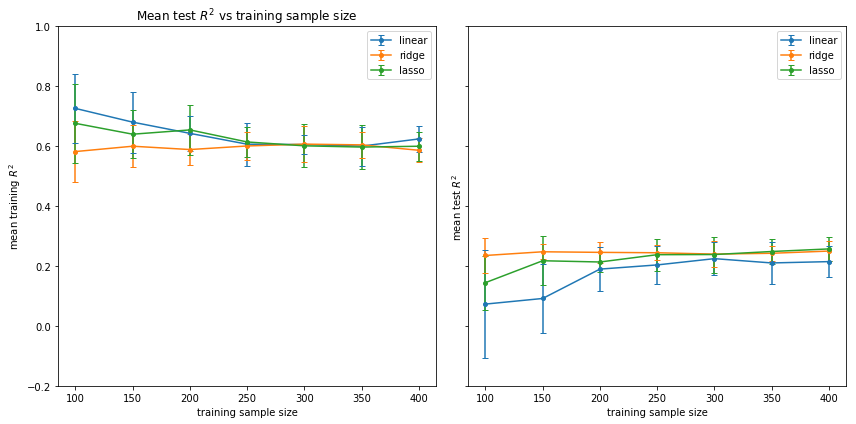

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
for model_r2 in models_r2:
    ax1.errorbar(sample_sizes, model_r2['train_r2_means'],
                 yerr=2*np.array(model_r2['train_r2_stds']),
                 label=model_r2['name'], fmt='-o', capsize=3, markersize=4)
    ax2.errorbar(sample_sizes, model_r2['test_r2_means'],
                 yerr=2*np.array(model_r2['test_r2_stds']),
                 label=model_r2['name'], fmt='-o', capsize=3, markersize=4)
ax1.set_ylim((-0.2, 1))
ax1.set_xlabel('training sample size')
ax2.set_xlabel(ax1.get_xlabel())
ax1.set_ylabel('mean training $R^{2}$')
ax2.set_ylabel('mean test $R^{2}$')
ax1.set_title('Mean training $R^{2}$ vs training sample size')
ax1.set_title('Mean test $R^{2}$ vs training sample size')
ax1.legend()
ax2.legend()
fig.tight_layout()

The mean training $R^2$ is highest for the Linear regression model over almost all training sample sizes as it overfits to the training data. The Lasso regression model has a higher mean training $R^2$ than the Ridge regression model for all training sample sizes except the largest (400). As expected, the mean training $R^2$ generally decreases with training sample size as it becomes more difficult for the models to fit to the data.

The mean test $R^2$ values are much lower than the corresponding training values as expected as we are out-of-sample. The Ridge regression model has the highest mean test $R^2$ over almost all training examples except the largest where it is overtaken by the Lasso regression model. Unsurprisingly, due to the overfitting, the Linear regression model has the poorest out-of-sample performance over all training sample sizes. 

We can see that the width of the confidence intervals are getting smaller and thus improving as the training sample size increases (for both the training and test $R^2$ values) due to the standard error decreasing. In fact proportional to $\frac{1}{\sqrt n}$ where n is the sample size.

Based on the plots, I would recommend the Ridge regression be used when one needs to fit a regression model using a small training sample of under 350 points. Should one have 400 points I would recommend the use of Lasso regression instead.

## Part (g): Polynomial & Interaction Terms

Moving beyond linear models, we will now try to improve the performance of the regression model in Part (b) from HW 3 by including higher-order polynomial and interaction terms. 

- For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a multiple regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in Part (b) from HW 3? Using a t-test, find out which of estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

- Fit a multiple linear regression model with additional interaction terms $\mathbb{I}_{month = 12} \times temp$ and $\mathbb{I}_{workingday = 1} \times \mathbb{I}_{weathersit = 1}$ and report the test $R^2$ for the fitted model. How does this compare with the $R^2$ obtained using linear model in Part (b) from HW 3? Are the estimated coefficients for the interaction terms statistically significant at a significance level of 5%?

First we fit the model with the polynomial terms

In [12]:
def create_poly_terms(X, predictors, powers=[2, 3, 4]):
    sorted_powers = sorted(powers)
    poly_terms = pd.DataFrame()
    for power in sorted_powers:
        poly_terms = pd.concat((poly_terms, X[predictors]**power), axis=1)
    poly_terms.columns = np.ravel([X[predictors].columns + '^' + str(power)
                                   for power in powers])
    Xpoly = X.join(poly_terms)
    return Xpoly

In [13]:
continous_predictors = ['temp', 'atemp', 'humidity', 'windspeed']
Xtrain_poly = create_poly_terms(Xtrain, continous_predictors)
Xtest_poly = create_poly_terms(Xtest, continous_predictors)

In [14]:
ols_poly = OLS(ytrain, sm.add_constant(Xtrain_poly))
ols_poly_results = ols_poly.fit()
print('Test R^2 =',
      r2_score(ytest,
               ols_poly_results.predict(sm.add_constant(Xtest_poly))))
print()
print('Predictor p-values:')
print(ols_poly_results.pvalues.drop('const'))

Test R^2 = 0.293959291219576

Predictor p-values:
season_2         0.092840
season_3         0.002583
season_4         0.001256
month_2          0.428073
month_3          0.494851
month_4          0.513854
month_5          0.126698
month_6          0.037698
month_7          0.059759
month_8          0.021659
month_9          0.105405
month_10         0.134872
month_11         0.163624
month_12         0.247511
day_of_week_1    0.550179
day_of_week_2    0.470708
day_of_week_3    0.449470
day_of_week_4    0.870538
day_of_week_5    0.249713
day_of_week_6    0.057033
weather_2        0.763811
weather_3        0.056870
temp             0.310969
atemp            0.209347
humidity         0.000029
windspeed        0.002951
holiday          0.603677
workingday       0.020369
temp^2           0.027402
atemp^2          0.137276
humidity^2       0.730036
windspeed^2      0.788028
temp^3           0.975117
atemp^3          0.217818
humidity^3       0.720833
windspeed^3      0.493942
temp^4        

The $R^2$ of this model on the test set is higher than that of the linear model fitted in Part (b) from HW 3. We can see that using a t-test, the estimated coefficients of the following parameters for the polynomial terms are statistically significant at a significance level of 5%:
- season_3
- season_4
- month_6         
- month_8          
- humidity         
- windspeed       
- workingday       
- temp^2           

Now we fit the model with the interaction terms.

In [15]:
def create_interaction_terms(X):
    month_terms = X.month_12 * X.temp
    month_terms.name = 'temp_int'
    # if indicators of weather_2 and weather_3 (no entries for weather_4)
    # sum to 0 then weather_1 = 1, otherwise weather_1 = 0
    Xweather_1 = 1 - (X.weather_2 + X.weather_3)
    weather_terms = X.workingday * Xweather_1
    weather_terms.name = 'weather_int'
    Xint = X.join((month_terms, weather_terms))
    return Xint

In [16]:
Xtrain_int = create_interaction_terms(Xtrain)
Xtest_int = create_interaction_terms(Xtest)

In [17]:
ols_int = OLS(ytrain, sm.add_constant(Xtrain_int))
ols_int_results = ols_int.fit()
print('Test R^2 =',
      r2_score(ytest,
               ols_int_results.predict(sm.add_constant(Xtest_int))))
print()
print('Predictor p-values:')
print(ols_int_results.pvalues.drop('const')[-2:])

Test R^2 = 0.28120865835372255

Predictor p-values:
temp_int       0.153104
weather_int    0.375336
dtype: float64


The $R^2$ of this model on the test set is higher than that of the linear model fitted in Part (b) from HW 3. We can see that using a t-test, the estimated coefficients of the interaction terms are not statistically significant at a significance level of 5%.

## Part (h): PCA to deal with high dimensionality

We would like to fit a model to include all main effects, polynomial terms up to the $4^{th}$ order, and all interactions between all possible predictors and polynomial terms (not including the interactions between $X^1_j$, $X^2_j$, $X^3_j$, and $X^4_j$ as they would just create higher order polynomial terms).  

- Create an expanded training set including all the desired terms mentioned above.  What are the dimensions of this 'design matrix' of all the predictor variables?   What are the issues with attempting to fit a regression model using all of these predictors?

- Instead of using the usual approaches for model selection, let's instead use principal components analysis (PCA) to fit the model.  First, create the principal component vectors in python (consider: should you normalize first?).  Then fit 5 different regression models: (1) using just the first PCA vector, (2) using the first two PCA vectors, (3) using the first three PCA vectors, etc...  Briefly summarize how these models compare in the training set.

- Use the test set to decide which of the 5 models above is best to predict out of sample.  How does this model compare to the previous models you've fit?  What are the interpretations of this model's coefficients?

In [18]:
Xtrain_poly_all = PolynomialFeatures(4).fit_transform(Xtrain)
Xtest_poly_all = PolynomialFeatures(4).fit_transform(Xtest)
Xtrain_poly_all.shape

(331, 35960)

We see that the dimensions of the 'design matrix' of all main effects, polynomial terms up to the 4th order, and all interactions between possible predictors and polynomical terms is 331 x 35960. Clearly, we have a situation in which the feature space is of high dimensionality, namely, the number of features is (much) higher than the number of observations. The issues with attempting to fit a regression model using all of the predictors are the following:
- **Overfitting** where the model is unnecessarily complex in the sense that it captures the random noise in data rather than the relationship between the predictors and the response variable. This causes the model to lose predictive power on new unseen data.
- **Model unidentifiablity** where we have more parameters than observations. We will not be able to uniquely determine 35960 parameters with only 331 observations.
- **Model interpretability** in the sense that there will be many redudant variables. We are only interested in sets of predictors that have a significant effect on the response. This is so that we can try to understand why the model makes certain predictions on new unseen data.
- **Computational performance** in the sense of longer training and/or predictions times and higher memory requirements.

It is clear that we will need a dimensionality reduction technique. We will use Principal Component Analysis (PCA) for model selection. Note that we do not normalize here since in the preprocessing step of part (b) HW3 we already standardized the continuous predictors. As we can see, the scales of the variables are not vastly different due to this.

In [19]:
Xtrain.describe()

,season_2,season_3,season_4,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,day_of_week_5,day_of_week_6,weather_2,weather_3,temp,atemp,humidity,windspeed,holiday,workingday
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,...,331.000000,331.000000,331.000000,331.000000,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,331.000000,331.000000
mean,0.259819,0.265861,0.256798,0.066465,0.075529,0.078550,0.102719,0.072508,0.093656,0.081571,...,0.145015,0.135952,0.329305,0.030211,-4.829973e-17,-1.046494e-16,-7.996289e-16,1.534858e-15,0.033233,0.670695
std,0.439199,0.442459,0.437528,0.249471,0.264643,0.269442,0.304051,0.259719,0.291790,0.274124,...,0.352649,0.343256,0.470672,0.171428,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.179515,0.470672
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-2.503291e+00,-2.572131e+00,-2.648736e+00,-2.152869e+00,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-8.504011e-01,-8.603176e-01,-7.452412e-01,-7.381149e-01,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,8.772587e-02,1.466312e-01,-6.562743e-03,-1.579037e-01,0.000000,1.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,8.024892e-01,7.508005e-01,7.055719e-01,5.693478e-01,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.874634e+00,1.959139e+00,2.362380e+00,2.949989e+00,1.000000,1.000000


OK let's perform the PCA regression for a range of 1 to 5 principal eigenvectors.

In [20]:
train_r2 = {}
test_r2 = {}
for num_comps in range(1, 6):
    pca = PCA(n_components=num_comps, random_state=10)
    pca.fit(Xtrain_poly_all)
    Xtrain_poly_pca = pca.transform(Xtrain_poly_all)
    Xtest_poly_pca = pca.transform(Xtest_poly_all)

    lin_reg = LinearRegression()
    lin_reg.fit(Xtrain_poly_pca, ytrain)
    train_r2[num_comps] = lin_reg.score(Xtrain_poly_pca, ytrain)
    test_r2[num_comps] = r2_score(ytest, lin_reg.predict(Xtest_poly_pca))

In [21]:
print('Train R^2 for number of principal components:')
print(train_r2)
print('Test R^2 for number of principal components:')
print(test_r2)

Train R^2 for number of principal components:
{1: 0.09752686978478908, 2: 0.12690890738265936, 3: 0.18421512941869822, 4: 0.24114465546876052, 5: 0.24155840691027952}
Test R^2 for number of principal components:
{1: 0.01812511244563897, 2: 0.07139251377119182, 3: 0.05610611814617772, 4: 0.15528296486647675, 5: 0.15619731671647674}


We can see that as we add more of the principal component eigenvectors in the model that the training set $R^2$ is increasing as the model is able to explain more of the variation in the response.

The highest test set $R^2$ is from the model with 5 principle components and therefore it is the best to predict out of sample.  However, we see that this model is worse than the previous models we have fit. The model's coefficients represent how much the predictor changes for a unit change of the corresponding principal component (linear combination of the original predictors). For completeness, we show the model coefficients, principal components, eigenvalues and the proportion of variance explained by each principal component.  

In [22]:
pca = PCA(n_components=max(test_r2.keys(), key=(lambda key: test_r2[key])),
          random_state=10)
pca.fit(Xtrain_poly_all)
Xtrain_poly_pca = pca.transform(Xtrain_poly_all)
Xtest_poly_pca = pca.transform(Xtest_poly_all)

lin_reg = LinearRegression()
lin_reg.fit(Xtrain_poly_pca, ytrain)
print('Model coefficients', lin_reg.coef_)
print('Principal components (eigenvectors)', pca.components_)
print('Explained variances (eigenvalues)', pca.explained_variance_)
print('Explained variance ratios', pca.explained_variance_ratio_)

Model coefficients [-37.89323906 -29.59152452 -55.75205126  63.78258916   5.75880369]
Principal components (eigenvectors) [[-1.15513556e-18 -2.72208776e-03 -3.77998533e-03 ...  0.00000000e+00
   0.00000000e+00 -1.90685495e-03]
 [-7.17245117e-17 -5.49833530e-03  3.05936495e-03 ... -0.00000000e+00
  -0.00000000e+00 -2.94260660e-03]
 [ 1.76700610e-16  7.99183481e-03 -2.21363812e-02 ... -0.00000000e+00
  -0.00000000e+00  5.36517984e-04]
 [ 1.14252859e-16  8.26576738e-05  3.05081754e-02 ...  0.00000000e+00
   0.00000000e+00  3.52787503e-03]
 [-2.72859794e-16 -1.89095060e-03  3.35896908e-03 ...  0.00000000e+00
   0.00000000e+00  1.36356625e-04]]
Explained variances (eigenvalues) [254.39355127 125.67604625  69.05347258  52.41298853  46.72015602]
Explained variance ratios [0.22773091 0.11250411 0.06181607 0.04691965 0.04182348]


## Part (i): Beyond Squared Error

We have seen in class that the multiple linear regression method optimizes the Mean Squared Error (MSE) on the training set. Consider the following alternate evaluation metric, referred to as the Root Mean Squared Logarthmic Error (RMSLE):

$$
\sqrt{\frac{1}{n}\sum_{i=1}^n (log(y_i+1) - log(\hat{y}_i+1))^2}.
$$

The *lower* the RMSLE the *better* is the performance of a model. The RMSLE penalizes errors on smaller responses more heavily than errors on larger responses. For example, the RMSLE penalizes a prediction of $\hat{y} = 15$ for a true response of $y=10$ more heavily than a prediction of $\hat{y} = 105$ for a true response of $100$, though the difference in predicted and true responses are the same in both cases. 

This is a natural evaluation metric for bike share demand prediction, as in this application, it is more important that the prediction model is accurate on days where the demand is low (so that the few customers who arrive are served satisfactorily), compared to days on which the demand is high (when it is less damaging to lose out on some customers).

The following code computes the RMSLE for you:

In [23]:
#--------  rmsle
# A function for evaluating Root Mean Squared Logarithmic Error (RMSLE)
# of the linear regression model on a data set
# Input: 
#      y_test (n x 1 array of response variable vals in testing data)
#      y_pred (n x 1 array of response variable vals in testing data)
# Return: 
#      RMSLE (float) 

def rmsle(y, y_pred):     
    # Evaluate sqaured error, against target labels
    # rmsle = \sqrt(1/n \sum_i (log (y[i]+1) - log (y_pred[i]+1))^2)
    rmsle_ = np.sqrt(np.mean(np.square(np.log(y+1) - np.log(y_pred+1))))
    
    return rmsle_

Use the above code to compute the training and test RMSLE for the polynomial regression model you fit in Part (g). 

You are required to develop a strategy to fit a regression model by optimizing the RMSLE on the training set. Give a justification for your proposed approach. Does the model fitted using your approach yield lower train RMSLE than the model in Part (g)? How about the test RMSLE of the new model? 

**Note:** We do not require you to implement a new regression solver for RMSLE. Instead, we ask you to think about ways to use existing built-in functions to fit a model that performs well on RMSLE. Your regression model may use the same polynomial terms used in Part (g).

In [24]:
ytrain_pred_poly = ols_poly_results.predict(
    sm.add_constant(Xtrain_poly))
train_index_neg_values = ytrain_pred_poly[
    ytrain_pred_poly < 0].index  # drop 3 negative predictions
train_rmsle = rmsle(ytrain.drop(index=train_index_neg_values),
                    ytrain_pred_poly.drop(index=train_index_neg_values))

ytest_pred_poly = ols_poly_results.predict(sm.add_constant(Xtest_poly))
test_index_neg_values = ytest_pred_poly[
    ytest_pred_poly < 0].index  # drop 4 negative predictions
test_rmsle = rmsle(ytest.drop(index=test_index_neg_values),
                   ytest_pred_poly.drop(index=test_index_neg_values))

print('Train RMSLE ', train_rmsle)
print('Test RMSLE ', test_rmsle)

Train RMSLE  0.31064487734756446
Test RMSLE  0.5020243957632905


If we substitute $log({y}_i+1)$ for ${y}_i$ and $log(\hat{y}_i+1)$ for $\hat{y}_i$  in the Root Mean Squared Logarithmic Error (RMSLE) error above  we get the Root Mean Squared Error (RMSE):

$$
\sqrt{\frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2}.
$$

Since the square root function is monotonic, minimizing the RMSE on the training set is the same as minimizing Mean Squared Error (MSE) on the training set. So if we make the above substitution then we can use the standard multiple linear regression method that optimizes the MSE on the training set to do so for the RMSLE.

In [25]:
log_ytrain = np.log(ytrain + 1)
log_ytest = np.log(ytest + 1)

ols_poly_log = OLS(log_ytrain, sm.add_constant(Xtrain_poly))
ols_poly_log_results = ols_poly_log.fit()
ytrain_pred_poly_log = ols_poly_log_results.predict(
    sm.add_constant(Xtrain_poly))
train_rmsle = mean_squared_error(log_ytrain, ytrain_pred_poly_log)

ytest_pred_poly_log = ols_poly_log_results.predict(sm.add_constant(Xtest_poly))
test_rmsle = rmsle(log_ytest, ytest_pred_poly_log)

print('Train RMSLE ', train_rmsle)
print('Test RMSLE ', test_rmsle)

Train RMSLE  0.08477996037881162
Test RMSLE  0.0638178280003674


We can see that the model fitted using this approach yields a much lower train and test RMSLE than the model in Part (g). Interestingly, the test RMSLE of the new model is also lower than its train RMSLE. 

## Part (j): Dealing with Erroneous Labels

Due to occasional system crashes, some of the bike counts reported in the data set have been recorded manually. These counts are not very unreliable and are prone to errors. It is known that roughly 5% of the labels in the training set are erroneous (i.e. can be arbitrarily different from the true counts), while all the labels in the test set were confirmed to be accurate. Unfortunately, the identities of the erroneous records in the training set are not available. Can this information about presence of 5% errors in the training set labels (without details about the specific identities of the erroneous rows) be used to improve the performance of the model in Part (g)? Note that we are interested in improving the $R^2$ performance of the model on the test set (not the training $R^2$ score). 

As a final task, we require you to come up with a strategy to fit a regression model, taking into account the errors in the training set labels. Explain the intuition behind your approach (we do not expect a detailed mathematical justification). Use your approach to fit a regression model on the training set, and compare its test $R^2$ with the model in Part (g).

**Note:** Again, we do not require you to implement a new regression solver for handling erroneous labels. It is sufficient that you to come up with an approach that uses existing built-in functions. Your regression model may use the same polynomial terms used in Part (g).

Since we know that roughly 5% of the labels in the training set are erroneous, we know that the model in Part (g) is fitting to the noise in these training labels. This is bad as it has the effect of reducing the $R^2$ performance of the model on the test set. If we knew which labels were erroneous we would just remove these observations from the training set. However, since we do not know which labels are erroneous, the best we can do is to try training with as many 95% subsets of the training data as possible. Our aim will be to fit as little of the noise in the training examples as possible, thereby improving the $R^2$ performance of the model in the test set. We will then select the model with the highest $R^2$ performance on the test set.

In [26]:
r2_results = {}
for trial in range(1000):
    indexes_to_drop = np.random.choice(
        ytrain.shape[0], size=int(ytrain.shape[0] * .05), replace=False)
    ols_poly = OLS(ytrain.drop(indexes_to_drop),
                   sm.add_constant(Xtrain_poly.drop(indexes_to_drop)))
    ols_poly_results = ols_poly.fit()
    test_r2 = r2_score(ytest, ols_poly_results.predict(
        sm.add_constant(Xtest_poly)))
    r2_results[test_r2] = indexes_to_drop
max_r2 = max(r2_results)
print('Max test R^2 = {0} when these observation indexes are dropped:\n{1}'
      .format(max_r2, r2_results[max_r2]))

Max test R^2 = 0.31891408058907755 when these observation indexes are dropped:
[174 275 201 151 294  60  29  82 299   3 242 251 327 180 195  78]


We can see that the test $R^2$ of the model that we found is higher than that of the model in Part (g).

---
--_

# APCOMP209a - Homework Question



##  Question 1: Student's t MLE

Use Maximum Likelihood Estimation to generate a linear regression model on the data provided in ``beerdata.csv`` considering two statistical models for noise: a) iid Normal and b) iid Student's t-distribution with $\nu=5$ and scale factor σ=0.5.  

Compare the two models performances and comment why it is perhaps appropriate to use the Student's t-distribution instead of the Normal? 





HINTS:
1. Use the probability density function for the Student's t distribution  with location μ and scale factor σ.
2. If the MLE regressions coefficients can not be derived analytically consider numerical methods.
3. You can use sklearn or statsmodel for the Normal case 




Let's read in the data first.

In [27]:
beerdata = pd.read_csv('../hwassets/data/beerdata.csv', usecols=(1, 2))
beerdata.head()

,x,y
0,0.760083,9.616565
1,0.766794,8.652492
2,0.504173,7.653462
3,0.357411,7.984081
4,0.730932,9.080448


Let's visualize the data.

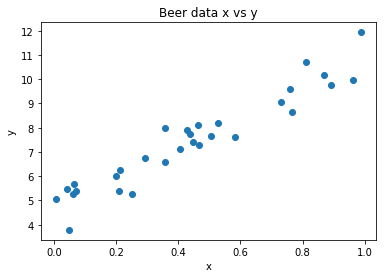

In [28]:
x = beerdata.x.values.reshape(-1, 1)
y = beerdata.y
plt.plot(x, y, 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Beer data x vs y');

Yes it seems we can fit a linear regression line to this data.

As was shown in class, the MLE for linear regression which assumes Gaussian (normal) noise is the Mean Squared Error (MSE). So let's fit this model now.

In [29]:
beer_reg = LinearRegression().fit(x, y)
print(beer_reg.score(x, y))
mean_squared_error(y, beer_reg.predict(x))

0.9079238029356782


0.3359148856221863

Clearly MLE for linear regression which assumes student t noise is not easy. Exercise (2) of this [lecture](http://www.stat.cmu.edu/~cshalizi/mreg/15/lectures/06/lecture-06.pdf) seems to suggests that it is possible but challenging to write down the MLE for this situation. I haven't found any derivations of this in the brief Google search I did. Section (1.1) of this [paper](https://www.researchgate.net/publication/318294582_Robust_Lasso_Regression_with_Student-t_Residuals) suggests "fitting a regression modelwith t-distributed errors using maximum likelihood can be eﬃciently performed using the expectation-maximisation (EM) algorithm". This is something to come back to when I know more about that algorithm.

Clearly this question is addressing "the situation in many practical fields (e.g., finance and geology) it is common to encounter noise whose distribution has much heavier tails than any Gaussian
could give us. One way to model this is with t distributions."

## Question 2 (continued from HW2) 

Read sections 1 and 2 of this [paper](https://www.researchgate.net/profile/Roberto_Togneri/publication/45094554_Linear_Regression_for_Face_Recognition/links/09e4150d243bd8b987000000/Linear-Regression-for-Face-Recognition.pdf). 

Briefly, the model leverages the concept that "patterns from a single-object class lie on a linear subspace."   It also makes use of the idea of linear regression as a problem about projections.  In this case, given a vector $y$, the goal is to find the subspace induced by $\mathrm{Col} \, \mathbf X$ that produced the 'closest' projection vector $\widehat y$ to the original $y$.  

### Question 2a

As discussed in the paper, our face dataset contains cleaned images of faces belonging to different people. Assuming that patterns (faces) from one class (person) are elements of the same subspace, let's try to classify an unknown face using the method presented in the paper.  For each class $i$, we need to:

1. construct the $\mathbf H_i$ hat matrix from known faces, being careful to follow the column concatenation step described in the paper to convert an image into its vector representation;
2. calculate the predicted $\widehat y_i$, the closest vector in $\mathrm{Col} \, \mathbf X_i$ to $y$; and
3. calculate the magnitude of the difference vector between $y$ and $\widehat y_i$.

You should then be able to make a classification decision.

**Notes:**
- Use the provided code to download and re-sample the dataset.
- Follow the normalisation step in the paper to ensure the "maximum pixel value is 1".
- Your classifier should have approximately an 80% accuracy.
- Use the image plotting library of matplotlib to display one (or two) correctly classified faces and the known faces.
- Use the image plotting library of matplotlib to display one (or two) incorrectly classified faces and the known faces.
    
### Question 2b - Significant Faces
Select an example of a correctly classified face. Use statsmodels to investigate the most predictive columns (faces) that the model used in this regression:

(i) Which columns (i.e. faces) make the highest contribution to the projection?

(ii) Which columns (i.e. faces) are the least useful in making this projection?

Plot the correctly assigned face, and the two faces from the questions (i) and (ii). What do you notice about these faces?

In [30]:
from io import BytesIO
from zipfile import ZipFile
import urllib
import os

# Note that you may need to run the following command to install Python Image Library (PIL)
#pip install Pillow
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [31]:
# starter functions provided to students
def rgb2gray(rgb):
    '''
    function to convert RGB image to gray scale
    accepts 3D numpy array and returns 2D array with same dimensions
    as the first two dimensions of input
    '''
    
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def fetch_and_read_data(shape=(50,30)):
    
    '''
    Function to download image data, store in a local folder (note this is 18.4mb), only download the data when
    the local folder is not present, read in the images, downsample them to the specified shape (default = (50x30) (rows x cols))
    and finally split them into a four tuple return object.
    
    Returns:
        - 1) training image data (i.e. images that should form the predictor matrix in your solution)
        - 2) training image data labels (i.e. labels from 1 to 50 that identify which face (1) belongs to)
        - 3) testing image data (i.e. data that you should use to try and classify - note this forms the predictor variable in your regression)
        - 4) testing image data labels (i.e. the labels for (3) - this is to allow you to evaluate your model)
    
    ___________________
    Aside:
    If you want to change the sampling dimensions of your data, pass the shape = (x,y) argument to the method where
    y is the number of columns and x is the number of rows in the image.
    '''
    
    if not os.path.exists('./cropped_faces'):
        url = urllib.request.urlopen("http://www.anefian.com/research/GTdb_crop.zip")
        
        zipfile = ZipFile(BytesIO(url.read()))
        zipfile.extractall()
     
    data = []
    labels = []
    
    files = os.listdir('cropped_faces')
    for f in files:
        if '.jpg' in f:
            image = Image.open('cropped_faces/' + f)
            image = image.resize((shape[1], shape[0]))
            data.append(rgb2gray(np.asarray(image)))
            labels.append(int(f.split('_')[0][1:]) - 1)
            
    data = np.array(data)
    
    trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, stratify=labels)
    return np.array(trainX), np.array(testX), np.array(trainY), np.array(testY)

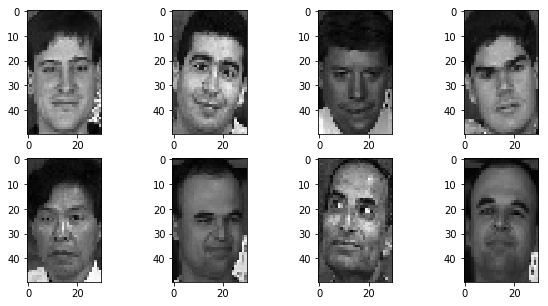

In [32]:
# starter code for the students
train_dataset, test_dataset, train_labels, test_labels = fetch_and_read_data()

# code to plot some of the images
fig, axes = plt.subplots(2,4,figsize=(10,5))
axes = axes.flatten()
[axes[i].imshow(train_dataset[i], cmap='gray') for i in range(len(axes))]
plt.show()

### Answer 2a

We first develop class specific models  Xi for i=0, 1,.., 49  by stacking the vectors.

In [33]:
def build_image_vectors(dataset, indexes=None):
    if indexes is None:
        indexes = list(range(dataset.shape[0]))

    image_vectors = []
    for m in indexes:
        image_vector = dataset[m].ravel('F')
        image_vector /= np.linalg.norm(image_vector)  # normalize
        image_vectors.append(image_vector)
    X = np.stack(image_vectors, axis=1)
    return X


def build_regressors(dataset, labels):
    X = []
    num_classes = labels.max() + 1
    for i in range(num_classes):
        class_indexes = np.argwhere(labels == i).ravel()
        Xi = build_image_vectors(dataset, indexes=class_indexes)
        X.append(Xi)
    return X

In [34]:
Xtrain = build_regressors(train_dataset, train_labels)
Xtest = build_image_vectors(test_dataset)

Next we project the unknown vector onto the subspaces spanned by the various X matrices using the "hat" interpretation of linear regression. We calculate the Euclidean distance measure between the predicted response vector and the original response vector and rule in favor of the class with minimum distance.

In [35]:
def predict(Xtrain, X):
    predictions = []
    for y in X.T:  # columns of X are the image vectors
        yi_hats = []
        for Xi in Xtrain:
            # project y onto ith subspace
            Xi_trans_y = np.dot(Xi.T, y)
            Xi_trans_Xi_inv = np.linalg.inv(np.dot(Xi.T, Xi))
            betai_hat = np.dot(Xi_trans_Xi_inv, Xi_trans_y)
            yi_hats.append(np.dot(Xi, betai_hat))

        # rule in favor of the class with minimum Euclidean distance
        distances = []
        for yi_hat in yi_hats:
            distance = np.linalg.norm(y - yi_hat)
            distances.append(distance)
        prediction = np.argmin(distances)
        predictions.append(prediction)
    return np.array(predictions)

In [36]:
y_predict = predict(Xtrain, Xtest)
accuracy = 100 * accuracy_score(y_true=test_labels, y_pred=y_predict)
print('Accuracy = {0}%'.format(accuracy))

Accuracy = 82.0%


Let's look at one correctly classified faces and the known faces.
and also one incorrectly classified faces and the known faces.

In [37]:
correct_faces = test_dataset[y_predict == test_labels]
labels_correct_faces = test_labels[np.argwhere(y_predict == test_labels)]
correct_idxs = np.where(np.isin(train_labels, labels_correct_faces[0]))[0]

incorrect_faces = test_dataset[y_predict != test_labels]
labels_incorrect_faces = y_predict[np.argwhere(y_predict != test_labels)]
incorrect_idxs = np.where(np.isin(train_labels, labels_incorrect_faces[0]))[0]

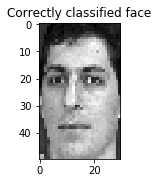

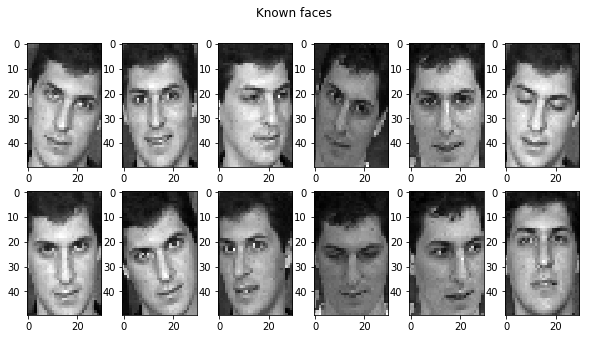

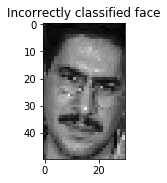

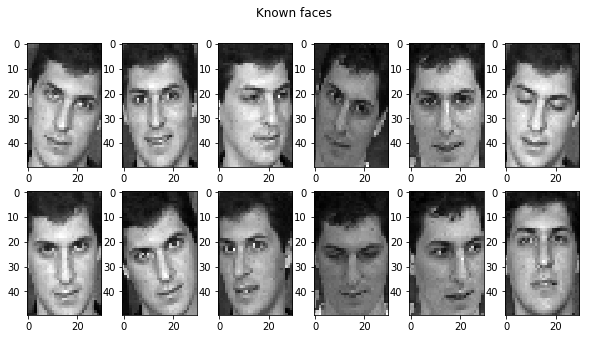

In [38]:
fig, axes = plt.subplots(figsize=(5, 2.5))
axes.imshow(correct_faces[0], cmap='gray')
plt.title('Correctly classified face')
plt.show()

fig, axes = plt.subplots(2, 6, figsize=(10, 5))
axes = axes.flatten()
[axes[i].imshow(train_dataset[correct_idxs][i], cmap='gray')
 for i in range(len(axes))]
fig.suptitle('Known faces')
plt.show()

fig, axes = plt.subplots(figsize=(5, 2.5))
axes.imshow(incorrect_faces[0], cmap='gray')
plt.title('Incorrectly classified face')
plt.show()

fig, axes = plt.subplots(2, 6, figsize=(10, 5))
axes = axes.flatten()
[axes[i].imshow(train_dataset[incorrect_idxs][i], cmap='gray')
 for i in range(len(axes))]
fig.suptitle('Known faces')
plt.show()

### Answer 2b

We select the correctly classified face above to investigate the most predictive columns (faces) that the model used in this regression.

In [39]:
Xtrain_df = pd.DataFrame(Xtrain[labels_correct_faces[0][0]],
                         columns=['face_' + str(face) for face in correct_idxs])
Xtrain_df.head()

,face_23,face_33,face_159,face_305,face_330,face_392,face_428,face_439,face_502,face_531,face_549,face_580
0,0.020915,0.017321,0.008331,0.012570,0.003825,0.019042,0.008354,0.009234,0.018432,0.003904,0.006588,0.017785
1,0.019279,0.015327,0.007997,0.012640,0.003997,0.016006,0.006406,0.008078,0.015302,0.006297,0.005091,0.014950
2,0.016910,0.013646,0.006751,0.011319,0.002396,0.014146,0.006963,0.007246,0.011057,0.003797,0.004333,0.009641
3,0.014929,0.008978,0.006720,0.011319,0.003290,0.015251,0.007043,0.006656,0.008743,0.003812,0.005191,0.007568
4,0.013838,0.007777,0.006989,0.011319,0.003886,0.014143,0.007814,0.006870,0.007029,0.003285,0.004383,0.007738


In [40]:
pred_results = OLS(correct_faces[0].ravel('F'),
                   sm.add_constant(Xtrain_df)).fit()
print('Predictor p-values:')
pred_results.pvalues.drop('const').sort_values()

Predictor p-values:


face_580    4.831003e-75
face_330    3.003012e-57
face_428    3.292588e-20
face_33     4.112129e-20
face_159    3.250942e-04
face_23     2.971665e-02
face_549    3.621345e-01
face_439    3.631861e-01
face_392    5.127951e-01
face_305    6.091953e-01
face_531    7.314130e-01
face_502    8.675055e-01
dtype: float64

We can see the most significant faces in the training data that make the highest contribution to the projection since they are the most statistically significant predictors at the top of the list. Whilst we see the least useful faces in making this projection at the bottom of the list as they are not statistically significant at all.

Let's now plot the most significant and least significant faces for comparison with the correctly assigned face. We see that the most significant face for the prediction has a similar orientation to the correctly assigned face whilst the least significant face has a very different orientation.

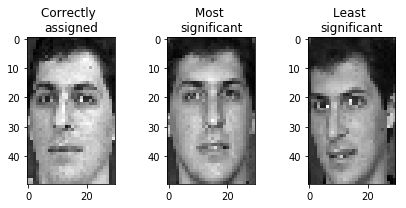

In [41]:
most_significant_face = int(pred_results.pvalues.drop(
    'const').sort_values().index[0].split('_')[1])
least_significant_face = int(pred_results.pvalues.drop(
    'const').sort_values().index[-1].split('_')[1])

fig, axes = plt.subplots(1, 3, figsize=(6, 3))
axes = axes.flatten()
[axes[i].imshow([correct_faces[0], train_dataset[most_significant_face],
                 train_dataset[least_significant_face]][i],
                cmap='gray') for i in range(len(axes))]
axes[0].set_title('Correctly \nassigned')
axes[1].set_title('Most \nsignificant')
axes[2].set_title('Least \nsignificant')
fig.tight_layout()
plt.show()